# Model classifier pour sélection de candidats avec biais minimal

This model is built for the Statup/Ekimetrcis Hackaton by team Tuxae. As we are working with complete beginners, and are beginners ourselves, an effort is made making the code clear and commenting it thouroughly.

## Dataset

StackOverflow's annual user-generated survey (over 70,000 responses from over 180 countries) of developers examines all aspects of the developer experience, from learning code to preferred technologies, version control and work experience.

From the survey results, we have built a dataset with the following columns:
- **Age**: age of the applicant, >35 years old or <35 years old *(categorical)*
- **EdLevel**: education level of the applicant (Undergraduate, Master, PhD...) *(categorical)*
- **Gender**: gender of the applicant, (Man, Woman, or NonBinary) *(categorical)*
- **MainBranch**: whether the applicant is a profesional developer *(categorical)*
- **YearsCode**: how long the applicant has been coding *(integer)*
- **YearsCodePro**: how long the applicant has been coding in a professional context, *(integer)*
- **PreviousSalary**: the applicant's previous job salary *(float)*
- **ComputerSkills**: number of computer skills known by the applicant *(integer)*
- **Employed**: target variable, whether the applicant has been hired *(categorical)*


## Imports

In [1]:
!pip install dalex

import numpy as np
import pandas as pd
import seaborn as sns
import dalex as dx
from dalex.fairness import resample, reweight
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2_contingency, pearsonr
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

import sklearn
sklearn.__version__

'1.2.2'

## Exploratory data analysis

In [2]:
file_path = "/content/stackoverflow_full.csv"
survey_data = pd.read_csv(file_path)

survey_data.head()

,Unnamed: 0,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0


A variable named "Unnamed: 0" seems to correspond be the row index, we drop it immediately as it won't be anything but distracting.

In [3]:
survey_data = survey_data.drop(columns=["Unnamed: 0"])

In [4]:
def flatten_categories(df):
  flattened_df = df.copy().dropna()
  flattened_df["Accessibility"].replace(["No", "Yes"], [0, 1], inplace=True)
  flattened_df["MentalHealth"].replace(["No", "Yes"], [0, 1], inplace=True)
  flattened_df["Age"].replace(["<35", ">35"], [0, 1], inplace=True)
  #flattened_df["Gender"].replace(["Man", "Woman", "NonBinary"], [0, 1, 2], inplace=True)
  gender_categories = flattened_df["Gender"].str.get_dummies()
  flattened_df = pd.concat([flattened_df, gender_categories], axis="columns").drop(columns=["Gender"])
  return flattened_df

corr_ready_data = flatten_categories(survey_data)
# np.array([np.array(corr_ready_data["Employed"]), np.array(corr_ready_data["Gender"])])

In [5]:
df = survey_data.copy()

country_total = df[["Country"]].value_counts()

# print("country_total", country_total)

df = df[df["Gender"] == "NonBinary"]

country_nonbinary = df[["Country"]].value_counts()

# print("country_nonbinary", country_nonbinary)

df = country_nonbinary / country_total

print("ratio", df)

ratio Country                             
Afghanistan                             0.058824
Albania                                 0.016949
Algeria                                      NaN
Andorra                                      NaN
Angola                                       NaN
                                          ...   
Venezuela, Bolivarian Republic of...         NaN
Viet Nam                                0.009524
Yemen                                        NaN
Zambia                                       NaN
Zimbabwe                                     NaN
Length: 172, dtype: float64


In [6]:
df = pd.crosstab(corr_ready_data["ComputerSkills"], corr_ready_data["Woman"])

res = chi2_contingency(df)
print(res.pvalue)

8.435423846742901e-30


Our goal is to have a quick overview of how every variable interacts. Categorical values need to be converted to numeric values for this to be computed in the correlation matrix. We especially want to compute `Accessibility`, `MentalHealth` and `Gender` categories to get a grasp of biases in the data.

<ipython-input-7-fca401c733c7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = corr_ready_data.corr()
<ipython-input-7-fca401c733c7>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pvalues = round(corr_ready_data.corr(method=lambda x, y: pearsonr(x, y)[1]), 4)


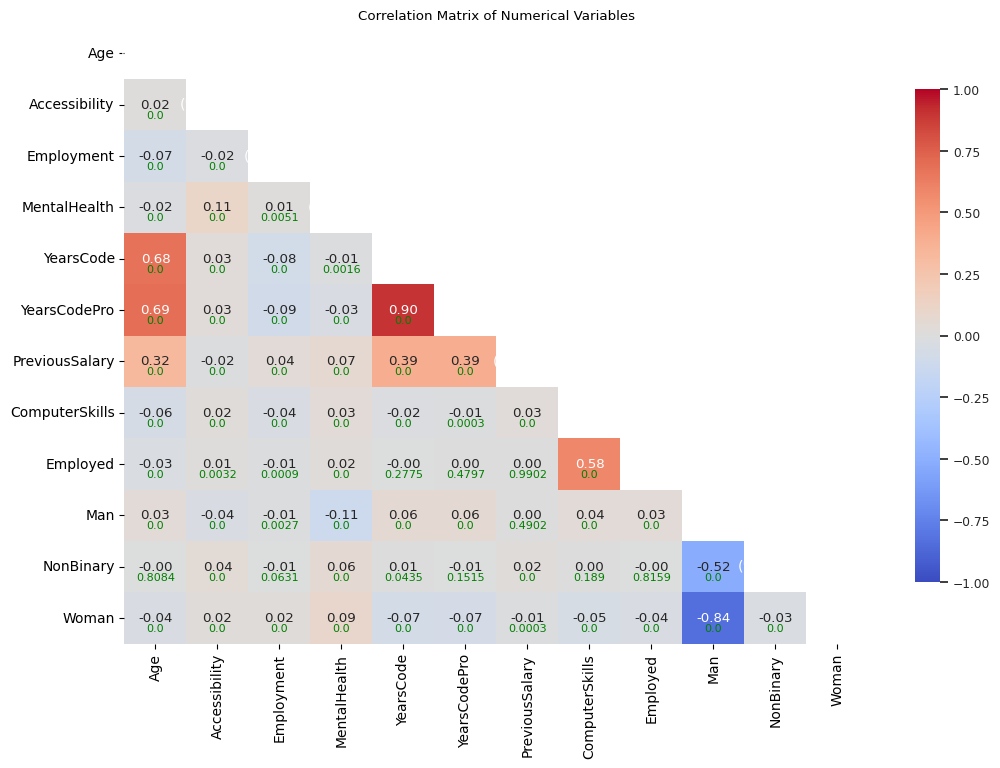

In [7]:
correlation_matrix = corr_ready_data.corr()
fig, ax = plt.subplots(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.set(style="white", font_scale=0.8)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'shrink': 0.8},
            ax=ax, vmin=-1, vmax=1, center=0, mask=mask)
pvalues = round(corr_ready_data.corr(method=lambda x, y: pearsonr(x, y)[1]), 4)
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i >= j:
            continue
        corr = f'{correlation_matrix.iloc[i, j]}',
        pval = pvalues.iloc[i, j]
        ax.text(j+0.5, i+0.5, corr, ha='center', va='center', fontsize=10, color='white')
        ax.text(i+0.5, j+0.7, pval, ha='center', va='center', fontsize=8, color='green')
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

We are interested in the correlations between `Employed` (8th column) and other variables. Interestingly, the correlation matrix seems to indicate that the dataset has a bias on gender but not on accessibility needs or mental health. These biases will be further explored later on.

## Pre-processing

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = survey_data.drop(columns=['Employed', 'Country', 'HaveWorkedWith'])
y = survey_data['Employed']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Training



In [9]:
# Random forest
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=3, random_state= 0))
])

# Decision tree
dc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# K-Nearest Neighbor
kn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Gradient Boosting
gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier())
])

In [10]:
rf.fit(X, y)
dc.fit(X, y)
kn.fit(X, y)
gb.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['Employment', 'YearsCode', 'YearsCodePro', 'PreviousSalary',
       'ComputerSkills'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Age', 'Accessibility', 'EdLevel', 'Gender', 'MentalHealth',
       'MainBranch'],
      dtype='object'))])),
                ('classifier', HistGradientBoostingClassifier())])

In [11]:
rf_cv_score = cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean()
dc_cv_score = cross_val_score(dc, X, y, cv=5, scoring='accuracy').mean()
kn_cv_score = cross_val_score(kn, X, y, cv=5, scoring='accuracy').mean()
gb_cv_score = cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean()

rf_cv_score, dc_cv_score, kn_cv_score, gb_cv_score

(0.7843104054932136,
 0.7050721955438682,
 0.6752471636157902,
 0.7843104054932136)

## Bias Mitigation

In [12]:
epsilon = 0.8
protected = X["Gender"]
privileged = "Man"

In [13]:
rf_exp = dx.Explainer(rf, X, y, verbose= False)
dc_exp = dx.Explainer(dc, X, y, verbose= False)
kn_exp = dx.Explainer(kn, X, y, verbose= False)
gb_exp = dx.Explainer(gb, X, y, verbose= False)

### Resampling

In [14]:
rf_u = copy(rf)
rf_p = copy(rf)
dc_u = copy(dc)
dc_p = copy(dc)
kn_u = copy(kn)
kn_p = copy(kn)
gb_u = copy(gb)
gb_p = copy(gb)

In [15]:
indices_uniform = resample(protected, y, verbose = False)

rf_indices_preferential = resample(protected, y, type = 'preferential', probs = rf_exp.y_hat, verbose = False)
dc_indices_preferential = resample(protected, y, type = 'preferential', probs = dc_exp.y_hat, verbose = False)
kn_indices_preferential = resample(protected, y, type = 'preferential', probs = kn_exp.y_hat, verbose = False)
gb_indices_preferential = resample(protected, y, type = 'preferential', probs = gb_exp.y_hat, verbose = False)

rf_u.fit(X.iloc[indices_uniform, :], y[indices_uniform])
rf_p.fit(X.iloc[rf_indices_preferential, :], y[rf_indices_preferential])
dc_u.fit(X.iloc[indices_uniform, :], y[indices_uniform])
dc_p.fit(X.iloc[dc_indices_preferential, :], y[dc_indices_preferential])
kn_u.fit(X.iloc[indices_uniform, :], y[indices_uniform])
kn_p.fit(X.iloc[kn_indices_preferential, :], y[kn_indices_preferential])
gb_u.fit(X.iloc[indices_uniform, :], y[indices_uniform])
gb_p.fit(X.iloc[gb_indices_preferential, :], y[gb_indices_preferential])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['Employment', 'YearsCode', 'YearsCodePro', 'PreviousSalary',
       'ComputerSkills'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Age', 'Accessibility', 'EdLevel', 'Gender', 'MentalHealth',
       'MainBranch'],
      dtype='object'))])),
                ('classifier', HistGradientBoostingClassifier())])

### Reweighting

Reweighting is unsupported with K-Nearest Neighbors.

In [16]:
weights = reweight(protected, y, verbose = False)

rf_weighted = copy(rf)
dc_weighted = copy(dc)
gb_weighted = copy(gb)

rf_kwargs = {rf_weighted.steps[-1][0] + '__sample_weight': weights}
dc_kwargs = {dc_weighted.steps[-1][0] + '__sample_weight': weights}
gb_kwargs = {gb_weighted.steps[-1][0] + '__sample_weight': weights}

rf_weighted.fit(X,y, **rf_kwargs)
dc_weighted.fit(X,y, **dc_kwargs)
gb_weighted.fit(X,y, **gb_kwargs)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['Employment', 'YearsCode', 'YearsCodePro', 'PreviousSalary',
       'ComputerSkills'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Age', 'Accessibility', 'EdLevel', 'Gender', 'MentalHealth',
       'MainBranch'],
      dtype='object'))])),
                ('classifier', HistGradientBoostingClassifier())])

### Comparison

We keep the comparison for Gradient Boosting as it is the model that's most sensitive to mitigation.

In [17]:
gb_exp_u = dx.Explainer(gb_u, X, y, verbose= False)
gb_exp_p = dx.Explainer(gb_p, X, y, verbose= False)
gb_exp_w = dx.Explainer(gb_weighted, X, y, verbose= False)

fobject_b = gb_exp.model_fairness(protected, privileged, label='base')
fobject_w = gb_exp_w.model_fairness(protected, privileged, label='weighted')
fobject_u = gb_exp_u.model_fairness(protected, privileged, label='res_unif')
fobject_p = gb_exp_p.model_fairness(protected, privileged, label='res_pref')

fobject_b.plot([fobject_w, fobject_u, fobject_p])

## Dumping models

In [18]:
from joblib import load, dump

dump(rf, "/content/rf.joblib")
dump(rf_weighted, "/content/rf_w.joblib")
dump(rf_u, "/content/rf_u.joblib")
dump(rf_p, "/content/rf_p.joblib")
dump(gb, "/content/gb.joblib")
dump(gb_weighted, "/content/gb_w.joblib")
dump(gb_u, "/content/gb_u.joblib")
dump(gb_p, "/content/gb_p.joblib")
dump(dc, "/content/dc.joblib")
dump(dc_weighted, "/content/dc_w.joblib")
dump(dc_u, "/content/dc_u.joblib")
dump(dc_p, "/content/dc_p.joblib")
dump(kn, "/content/kn.joblib")
# dump(kn_w, "/content/kn_w.joblib")
dump(kn_u, "/content/kn_u.joblib")
dump(kn_p, "/content/kn_p.joblib")

['/content/kn_p.joblib']